In [1]:
#We'll start by loading in some packages, in case Anaconda didn't do so already.
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import datetime
import xarray as xr
from pandas.plotting import autocorrelation_plot, lag_plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

First to read in our datasets. Note that the NJDEP aerial-count based chlorophyll-a data is very patchy, so we're dropping it from our analysis.

In [2]:
#Now to read in our datasets
##Creating "today" code
td = datetime.date.today()
today = td.strftime('%Y-%m-%d')
# print(today)

##Reading in precipitation data
##Note: We switched weather stations to get both temperature and precipitation data.
##The API code to download it was somehow corrupting the data. Dave and I have had to download the data manually to avert this.
precipFile = "./CapeMayWeather.csv"
precip = pd.read_csv(precipFile)
precip.index = pd.to_datetime(precip.index)
precip.head()

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT05,WT06,WT11
1970-01-01 00:00:00.000000000,USC00281351,"CAPE MAY 2 NW, NJ US",2005-01-01,0.00,0.0,0.0,65.0,38.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.000000001,USC00281351,"CAPE MAY 2 NW, NJ US",2005-01-02,0.00,0.0,0.0,50.0,38.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.000000002,USC00281351,"CAPE MAY 2 NW, NJ US",2005-01-03,0.00,0.0,0.0,61.0,37.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.000000003,USC00281351,"CAPE MAY 2 NW, NJ US",2005-01-04,0.00,0.0,0.0,62.0,44.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.000000004,USC00281351,"CAPE MAY 2 NW, NJ US",2005-01-05,0.12,0.0,0.0,46.0,40.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Reading in chlorophyll data
chloroFile = './projectData/Chloro1DayAggregate.nc'
chloro = xr.open_dataset(chloroFile)
chloroA = chloro.to_dataframe()
chloroA = chloroA.reset_index()
chloroA = chloroA.set_index('time')
chloroA = chloroA.resample('D').mean()
chloroA  = chloroA.reset_index()
chloroA = chloroA.dropna(axis=0,how="any")
chloroA.head()

,time,lat,lon,chl_oc3
0,2005-01-01,39.000753,-75.053811,4.853932
26,2005-01-27,39.000753,-75.053811,8.928359
30,2005-01-31,39.000753,-75.053811,4.105638
31,2005-02-01,39.000753,-75.053811,7.326336
32,2005-02-02,39.000753,-75.053811,8.445160


Now to re-inspect some signals.

C:\Users\cmiwi\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


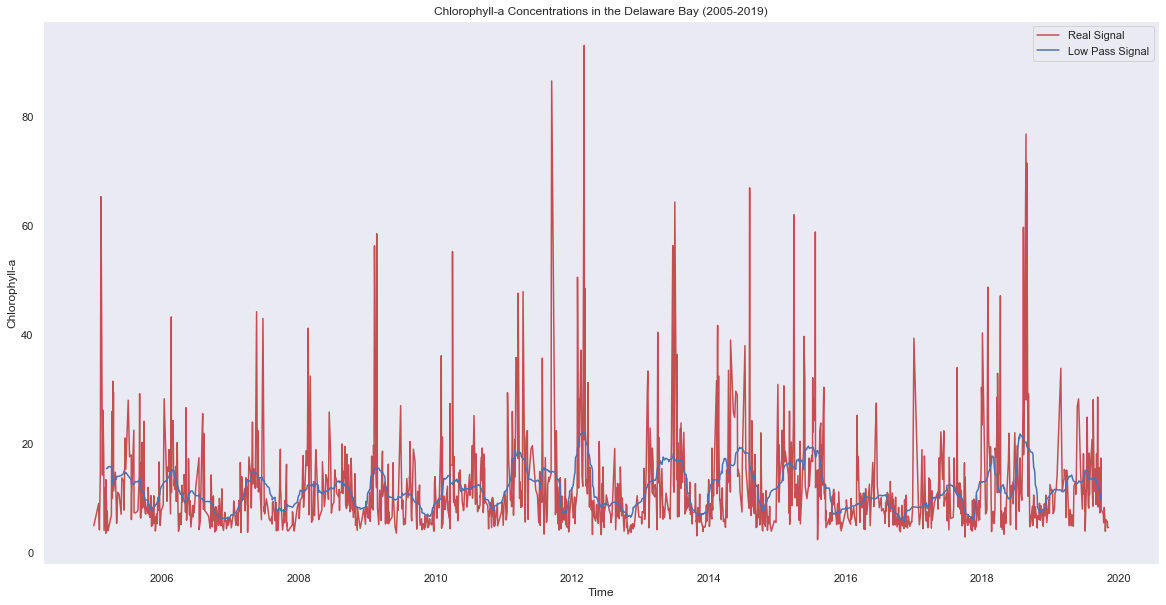

In [4]:
#Reading in and inspecting original signal

realChlSignal = chloroA.chl_oc3
windowSize = 30
lowPassChl = realChlSignal.rolling(windowSize, center = True).mean()

fig1 = plt.figure(figsize=(20, 10)) #figsize=(50, 20)
ax1 = fig1.add_subplot(111)
ax1.plot(chloroA['time'], chloroA['chl_oc3'], label='Real Signal', c='r')
ax1.plot(chloroA['time'], lowPassChl, label='Low Pass Signal', c='b')

plt.xlabel('Time')
plt.ylabel('Chlorophyll-a')
plt.title('Chlorophyll-a Concentrations in the Delaware Bay (2005-2019)')
ax1.legend()
ax1.grid()

In [ ]:
realTempSignal = precip.TMAX
windowSize = 30
lowPassTemp = realTempSignal.rolling(windowSize, center = True).mean()

fig2 = plt.figure(figsize=(20, 10)) #figsize=(50, 20)
ax2 = fig2.add_subplot(111)
ax2.plot(precip['DATE'], precip['TMAX'], label='Real Signal', c='r')
ax2.plot(precip['DATE'], lowPassTemp, label='Low Pass Signal', c='b')

plt.xlabel('Time')
plt.ylabel('Maximum Temperature')
plt.title('Maximum Temperatures at Cape May, NJ Weather Station (2005-2019)')
ax2.legend()
ax2.grid()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000002A579DBAEA0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
realPrecipSignal = precip.PRCP
windowSize = 30
lowPassPrecip = realPrecipSignal.rolling(windowSize, center = True).mean()

fig3 = plt.figure(figsize=(20, 10)) #figsize=(50, 20)
ax3 = fig3.add_subplot(111)
ax3.plot(precip['DATE'], precip['PRCP'], label='Real Signal', c='r')
ax3.plot(precip['DATE'], lowPassPrecip, label='Low Pass Signal', c='b')

plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.title('Precipitation at Cape May, NJ Weather Station (2005-2019)')
ax3.legend()
ax3.grid()

Alright. Now to try and run the model. Our model is:

chl_a = chl_a + alpha*temp(t) + beta*precip(t)

We can use a forward Euler integration enacted via a for loop for this, but we'll try something else first.

In [ ]:
#Do a Euler for loop!
#chl_a = chl_a + alpha*temp(t) + beta*precip(t)
#ime = np.linspace(precip.DATE[0], precip.size, precip.size)
##5431 days in our data set
time = np.linspace(0, 5431, 5431)
time = time.round(decimals=0)
time = time.astype(int)

chlModel = [0]
deltax = 1 #We want one prediction per day

# precip.TMAX.size
# time.size
# precip.head()

chlModel =  precip.TMAX[time] + precip.PRCP[time] #+ chlModel
windowSize = 30 #Haven't changed it.

lowPassModel = chlModel.rolling(windowSize, center=True).mean()

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(14,14))

ax[0].plot(chloroA['time'], lowPassChl, label = "Chlorophyll_a")
ax[0].plot(precip.DATE, lowPassModel, label = "Low Pass Model")

ax[1].plot(chloroA['time'], lowPassChl, label = "Chlorophyll_a")
ax[1].plot(precip.DATE, lowPassModel, label = "Low Pass Model")
ax[1].set_xlim(pd.Timestamp('2005-01-01'), pd.Timestamp('2015-01-01'))


Okay, that didn't work. Let's see if we can get a loop working.

In [ ]:
numDays = 5431
chlModel2 = np.zeros([numDays])
deltax = 1

for i in range (numDays):
    chlModel2[i] = deltax*(precip.TMAX[i-1] + precip.PRCP[i-1]) + chlModel2[i-1]
    
fig4 = plt.figure(figsize=(20, 10)) #figsize=(50, 20)
ax4 = fig4.add_subplot(111)
ax4.plot(chloroA['time'], lowPassChl, label = 'Real Chlorophyll-a')
ax4.plot(precip['DATE'], chlModel2, label='Model', c='r')